# Opdracht 2 - Convolutional Neural Networks


Het doel van deze opdracht is om image recognition te doen aan de hand van Convolutional Neural Networks (CNN). In een eerste deelopdracht ontwerp je een binaire CNN classifier voor het classificeren van foto's van lichaamscellen die al dan niet met malaria geïnfecteerd zijn. 

In een tweede deelopdracht zal je gezichtsherkenning uitvoeren via een multi-class CNN classifier.

In een derde deelopdracht train je een CNN die gezichten van niet-gezichten kan onderscheiden. Met deze classifier kan je vervolgens gezichtsdetectie uitvoeren. Daarbij is het niet de bedoeling om gezichten te herkennen, maar de locatie van al dan niet aanwezig gezichten in afbeeldingen te vinden en aan te duiden.

Na deze opdracht zal je vertrouwd zijn met:
- Implementeren van convolutional neural networks voor objectherkenning in afbeeldingen.
- Hyperparameter tuning van CNN's
- Weten hoe je transfer learning kan toepassen voor jouw eigen classificatie taak.
- Data/Image augmentation uitvoeren.
- Object detectie via een sliding window.


In [59]:
%matplotlib inline

import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import matplotlib.image as mpimg
from skimage.io import imread, imsave, imshow
from skimage import data, color, io, filters, morphology,transform, exposure, feature, util
from scipy import ndimage
import sklearn.metrics as metrics
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import re

#K.set_image_dim_ordering('tf')
plt.rcParams['image.cmap'] = 'gray'
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

print(tf.__version__)
if tf.__version__.split('.')[0]!='2':
    raise ImportError("Need tensorflow 2")

2.5.0


## Malaria Classification

Ontwerp en train een CNN dat is in staat is met Malaria geïnfecteerde cellen van niet-geïnfecteerde cellen te onderscheiden.

De data is te vinden in:
- './Malaria/train/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te trainen.
- './Malaria/train/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te trainen.
- './Malaria/test/infected/': afbeelding van met Malaria geïnfecteerde cellen om mee te testen.
- './Malaria/test/uninfected/': afbeeldingen van gezonde, niet-geïnfecteerde cellen om mee te testen.


1. Ontwerp in eerste instantie een eigen CNN. 
- Probeer de accuracy van het CNN op de test data zo hoog mogelijk te krijgen. Dit kan bijvoorbeeld omvatten: hyperparameter tuning van de het netwerk zelf, early stopping, image augmentation of eigen bedachte (pre)-processing technieken. 
- Stel nu dat aan het CNN de vereiste wordt gesteld dat het aantal false negatives (het netwerk voorspelt niet-geïnfecteerd terwijl ze wel geïnfecteerd zijn) op de test set maximaal 1% mag bedragen. Welke aanpassingen zou je doen? Voor deze aanpassingen uit en toon aan dat het aantal false negatives tot maximum 1% is gezakt. Welke accuracy haal je nog?

2. Voer transfer learning uit. Hertrain het VGG19 netwerk voor het classificeren van de al dan niet met Malaria geïnfecteerde cellen. Vergelijk de resultaten met deze van het eigen CNN in termen van accuraatheid, f1-score, snelheid van training, de benodigde hoeveelheid training data, etc.



### Eigen CNN

In [60]:
# Inlezen van de data

# Lezen en preprocessen 
infected_train_images = []
infected_test_images = []
uninfected_train_images = []
uninfected_test_images = []
y_infected_train = []
y_uninfected_train = []
y_infected_test = []
y_uninfected_test =[]

# read infected train_images
valid_images = [".jpg",".gif",".png"]

print("Read train infected")
train_infect_path = '/Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria/train/infected/'
train_infect_files = [os.path.join(train_infect_path, f) for f in os.listdir(train_infect_path) if os.path.splitext(f)[1].lower() in valid_images]
print(" %s --> %d images available"%(train_infect_path, len(train_infect_files)))

test_infect_path = '/Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria/test/infected/'
test_infect_files = [os.path.join(test_infect_path, f) for f in os.listdir(test_infect_path) if os.path.splitext(f)[1].lower() in valid_images]
print(" %s --> %d images available"%(test_infect_path, len(test_infect_files)))

train_uninfect_path = '/Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria/train/uninfected/'
train_uninfect_files = [os.path.join(train_uninfect_path, f) for f in os.listdir(train_uninfect_path) if os.path.splitext(f)[1].lower() in valid_images]
print(" %s --> %d images available"%(train_uninfect_path, len(train_uninfect_files)))

test_uninfect_path = '/Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria/test/uninfected/'
test_uninfect_files = [os.path.join(test_uninfect_path, f) for f in os.listdir(test_uninfect_path) if os.path.splitext(f)[1].lower() in valid_images]
print(" %s --> %d images available"%(test_uninfect_path, len(test_uninfect_files)))


Read train infected
 /Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria/train/infected/ --> 1000 images available
 /Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria/test/infected/ --> 1000 images available
 /Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria/train/uninfected/ --> 1000 images available
 /Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria/test/uninfected/ --> 1000 images available


In [61]:
d = []
for f in train_infect_files:
    im = imread(f) 
    d.append([f, 0, 1, im.shape[0], im.shape[1]])
for f in test_infect_files:
    im = imread(f) 
    d.append([f, 1, 1, im.shape[0], im.shape[1]])
for f in train_uninfect_files:
    im = imread(f) 
    d.append([f, 0, 0, im.shape[0], im.shape[1]])
for f in test_uninfect_files:
    im = imread(f) 
    d.append([f, 1, 0, im.shape[0], im.shape[1]])

df = pd.DataFrame(d, columns=["FileName", "Test", "Infected", "Heihgt", "Width"])    
display(df.head())
display(df.describe())


,FileName,Test,Infected,Heihgt,Width
0,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100
1,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100
2,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100
3,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100
4,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100


,Test,Infected,Heihgt,Width
count,4000.000000,4000.000000,4000.0,4000.0
mean,0.500000,0.500000,100.0,100.0
std,0.500063,0.500063,0.0,0.0
min,0.000000,0.000000,100.0,100.0
25%,0.000000,0.000000,100.0,100.0
50%,0.500000,0.500000,100.0,100.0
75%,1.000000,1.000000,100.0,100.0
max,1.000000,1.000000,100.0,100.0


**Comment:**
Keuze van scaleren naar een vierkantige afbeeling lijkt ok. De gemiddelde afbeelding is 103x103 pixels groot. 100x100 is dan ook een goede keuze als gemeenschappelijke resolutie van de beelden. 

In [62]:
image_size      = 50  # hoogte en breedte van de afbeeldingen na resizing. Pas gerust aan.
image_size      = 50  
grayscale       = False

from skimage.color import rgb2gray

imgs = []
for f in df.FileName:
    im = imread(f) 
    if grayscale:
        im = rgb2gray(im)
    im = transform.resize(im,(image_size,image_size),mode='constant',anti_aliasing=True)
    imgs.append(im)

df["data"]=imgs
display(df.head())
#display(df.describe())


,FileName,Test,Infected,Heihgt,Width,data
0,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
1,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100,"[[[0.00350112102223339, 0.0, 0.0], [0.00176221..."
2,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
3,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100,"[[[0.0, 0.0035129787921709607, 0.0], [0.0, 0.0..."
4,/Users/johanvekeman/Documents/Datasets/Home_Ma...,0,1,100,100,"[[[0.00350112102223339, 0.0, 0.0], [0.00176221..."


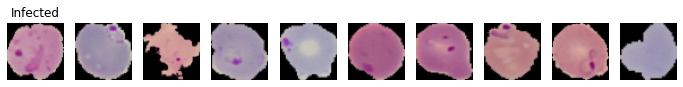

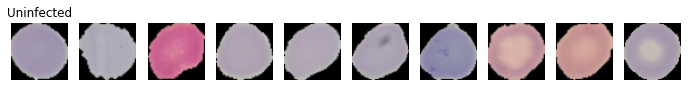

In [63]:
# Toon een afbeelding
images = df[df["Infected"]==1]["data"].iloc[0:10]

fig, axs = plt.subplots(1,10, figsize=(12,2))
axs[0].set_title("Infected")
for img, a in zip(images, axs):
    a.imshow(img)
    a.set_axis_off()

images = df[df["Infected"]==0]["data"].iloc[0:10]

fig, axs = plt.subplots(1,10, figsize=(12,2))
axs[0].set_title("Uninfected")
for img, a in zip(images, axs):
    a.imshow(img)
    a.set_axis_off()

**Comment:**
Uit de afbeeldingen blijkt dat er wel degelijk een duidelijk (voor een mens) verschil is tussen indected en niet infected.

In [64]:
# Creëer te de test set en training set. Zorg ervoor dat ze gerandomiseerd zijn.

nr_train_images = 1000  # Om het aantal afbeelding in de training set te beperken. Verhoog indien jouw systeem het toelaat.
#nr_train_images = len(df[df["Test"]==0])
nr_test_images  = 50   # Om het aantal afbeelding in de test set in eerste instantie te beperken. 
nr_test_images  = len(df[df["Test"]==1])

try: df.drop(["Heihgt", "Width"], axis=1, inplace=True) 
except: pass

df_train = df[df["Test"]==0].sample(nr_train_images)
df_test  = df[df["Test"]==1].sample(nr_test_images)
#display(df_train)

display(df_train.describe().loc[["count", "mean"]])
display(df_test.describe().loc[["count", "mean"]])


,Test,Infected
count,1000.0,1000.000
mean,0.0,0.499


,Test,Infected
count,2000.0,2000.0
mean,1.0,0.5


In [65]:
categorical = False

X_train = df_train["data"].values
y_train = df_train["Infected"].values

if categorical:
    y_train = to_categorical(y_train)

X_test = df_test["data"].values
y_test = df_test["Infected"].values

#print(X_train[0].reshape(50,50,1).shape)

X_train = np.stack(X_train, axis=0)
X_test  = np.stack(X_test,  axis=0)

if grayscale:
    X_train=X_train.reshape(-1,50,50,1)
    X_test=X_test.reshape(-1,50,50,1)

#print(X_train)

print("X train : ", X_train.shape)
print("y train : ", y_train.shape)

print("X test  : ", X_test.shape)
print("y test  : ", y_test.shape)



X train :  (1000, 50, 50, 3)
y train :  (1000,)
X test  :  (2000, 50, 50, 3)
y test  :  (2000,)


In [66]:
# Normalisatie van de data

#check min and max 
print("Range of input values : ", (X_train.min(), X_train.max()))


Range of input values :  (0.0, 0.9764672095783427)


**Comment:**
De data blijkt al tussen 0 en 1 te liggen. We gaan geen extra scaling meer moeten doen.

In [67]:
#helper functions 

# Plot history
def histplot(history, name):
    fig, axs = plt.subplots(1,2, figsize=(12,6))
    print(fig)

    axs[0].plot(history.history['loss'],'red',linewidth=3.0, label="loss")
    axs[0].plot(history.history['val_loss'],'blue',linewidth=3.0, label="val_loss")
    axs[0].legend()
    axs[0].set_xlabel('epochs')
    axs[0].set_ylabel('Training error')
    axs[0].set_ylim((0,1.5))
    axs[0].grid()
    axs[0].set_title(name)

    axs[1].plot(history.history['accuracy'],'red',linewidth=3.0, label="accuracy")
    axs[1].plot(history.history['val_accuracy'],'blue',linewidth=3.0, label="val_accuracy")
    axs[1].legend()
    axs[1].set_xlabel('epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid()
    fig.savefig(name+'.png')


def PlotRoc_pos(probs, y_test):
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.suptitle('Receiver Operating Characteristic Positive class')
    
    ax[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax[0].legend(loc = 'lower right')
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].grid()
    
    ax[1].plot(threshold, fpr, label='fpr')
    ax[1].plot(threshold, tpr, label='tpr')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].set_ylabel('Rate')
    ax[1].set_xlabel('Threshold')
    plt.show()
    return fpr, tpr, threshold 
    
def PlotRoc_neg(probs, y_test):

    preds = probs[:,1]
    fnr, tnr, threshold = metrics.roc_curve(y_test, preds, pos_label=0)
    roc_auc = metrics.auc(fnr, tnr)

    fig, ax = plt.subplots(1,2,figsize=(8,4))
    fig.suptitle('Receiver Operating Characteristic Negative class')
    
    ax[0].plot(fnr, tnr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax[0].legend(loc = 'lower right')
    ax[0].plot([0, 1], [0, 1],'r--')
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].set_ylabel('True Negative Rate')
    ax[0].set_xlabel('False Negative Rate')
    ax[0].grid()
    
    ax[1].plot(threshold, fnr, label='fnr')
    ax[1].plot(threshold, tnr, label='tnr')
    ax[1].legend()
    ax[1].grid()
    ax[1].set_xlim([0, 1])
    ax[1].set_ylim([0, 1])
    ax[1].set_ylabel('Rate')
    ax[1].set_xlabel('Threshold')
    plt.show()
    return fnr, tnr, threshold

In [68]:
# CNN, netwerk structuur

input_shape = X_train[0].shape

# Model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape)) 
#model.add(Conv2D(32, kernel_size=(3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu')) 
#model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))

#added for 100x100 case
# model.add(Conv2D(64, (3, 3), activation='relu')) 
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu')) 
#model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(100, activation='relu')) 

if categorical:
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
else:
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
model.summary()
#plot_model(model, 'model.png', show_shapes=True)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)             

In [69]:
# Trainen van het CNN

batch_size = 64 
epochs     = 50

# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 5)

history = model.fit(X_train, y_train, batch_size=batch_size, validation_split = 0.1, epochs=epochs, verbose=1,
                   callbacks=[es])


Epoch 1/50
 4/15 [=======>......................] - ETA: 0s - loss: 0.6958 - accuracy: 0.4883

2022-02-05 12:06:31.657978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 28ms/step - loss: 0.6948 - accuracy: 0.5078 - val_loss: 0.7012 - val_accuracy: 0.4100
Epoch 2/50
 7/15 [=============>................] - ETA: 0s - loss: 0.6908 - accuracy: 0.5201

2022-02-05 12:06:32.091218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 0s 22ms/step - loss: 0.6875 - accuracy: 0.5367 - val_loss: 0.7083 - val_accuracy: 0.4300
Epoch 3/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6864 - accuracy: 0.5589 - val_loss: 0.6698 - val_accuracy: 0.6200
Epoch 4/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6712 - accuracy: 0.5956 - val_loss: 0.7280 - val_accuracy: 0.4500
Epoch 5/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6503 - accuracy: 0.6278 - val_loss: 0.6995 - val_accuracy: 0.4800
Epoch 6/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6414 - accuracy: 0.6467 - val_loss: 0.6542 - val_accuracy: 0.6100
Epoch 7/50
15/15 [==============================] - 0s 22ms/step - loss: 0.6354 - accuracy: 0.6389 - val_loss: 0.6520 - val_accuracy: 0.6100
Epoch 8/50
15/15 [==============================] - 0s 22ms/step - loss: 0.5988 - accuracy: 0.7000 - val_loss: 0.7351 - val_accuracy: 0.5400
Epoch 9/50
15/15 [======

Figure(864x432)


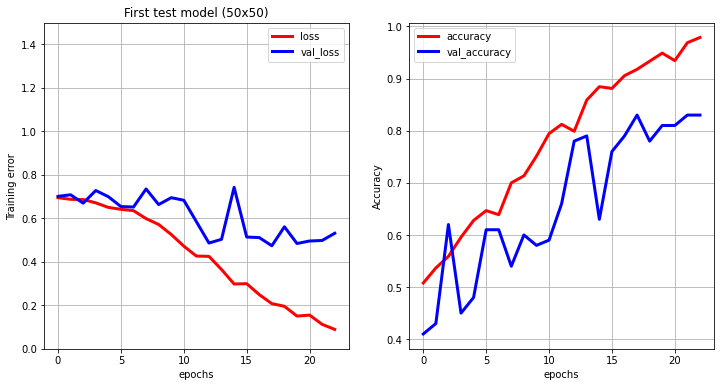

In [70]:

histplot(history, "First test model (50x50)")    

In [71]:
# model.load_weights('best_model.h5')

In [76]:
# Testen van het neuraal netwerk op de test set. Kijk naar de accuracy, recall, precision, f1-score en de ROC 
y_pred = model.predict_classes(X_test)

print("Accuracy score : %.1f"%(accuracy_score(y_test, y_pred) * 100)) 
print()
print(classification_report(y_test, y_pred))
cf = confusion_matrix(y_test, y_pred)
print("Confusion matrix : ")
print(cf)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy score : 89.0

              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1000
           1       0.93      0.84      0.88      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Confusion matrix : 
[[940  60]
 [159 841]]


In [78]:
model.save('/Users/johanvekeman/Documents/Datasets/Home_Malaria/Malaria_model.h5')
